## Learned Data Augmentation

Papers
* [RenderGAN: Generating Realistic Labeled Data](https://arxiv.org/abs/1611.01331)
* [Dataset Augmentation in Feature Space](https://arxiv.org/abs/1702.05538)
* [Learning to Compose Domain-Specific Transformations](https://arxiv.org/abs/1709.01643)
* [Data Augmentation Generative Adversarial Networks](https://arxiv.org/abs/1711.04340)
* [Data Augmentation in Emotion Classification Using GANs](https://arxiv.org/abs/1711.00648)
* [Neural Augmentation and Cycle GAN](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
* [Bayesian Data Augmentation Approach](https://arxiv.org/abs/1710.10564)
* [Larning To Model the Tail](https://papers.nips.cc/paper/7278-learning-to-model-the-tail)

Links
* https://blog.openai.com/requests-for-research-2/
* http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#4d4e495354

Approaches
1. Autoencoder: Encode --> Peturb/Interpolate --> Decode
2. Synthetic Dataset Generation with CGAN
3. Domain Adaption / Image-to-Image translation (CycleGAN)
4. Augmentation / Preprocessing Net + backprop classification loss

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys
p = os.path.join(os.path.dirname('__file__'), '..')
sys.path.append(p)
from common import *

## Dataset

In [106]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def get_cifar_loader(bs=64, trn_size=50000, tst_size=10000):
    trainTransform = torchvision.transforms.Compose([
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor()
    ])
    testTransform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])

    trainset = torchvision.datasets.CIFAR10(
        root='../data', train=True, download=True, transform=trainTransform)
    trainset.train_data = trainset.train_data[:trn_size]
    trainset.train_labels = trainset.train_labels[:trn_size]
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=bs, shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(
        root='../data', train=False, download=True, transform=testTransform)
    testset.test_data = testset.test_data[:tst_size]
    testset.test_labels = testset.test_labels[:tst_size]
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=bs, shuffle=False, num_workers=2)

    return trainloader, testloader

def plot_tensor(img, fs=(10,10), title=""):
    npimg = img.numpy()
    plt.figure(figsize=fs)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)

In [128]:
trn_loader, tst_loader = get_cifar_loader(bs=64, trn_size=5000, tst_size=2000)
inputs,targets = next(iter(train_loader))
len(trn_loader.dataset), len(tst_loader.dataset), inputs.size(), targets.size()

Files already downloaded and verified
Files already downloaded and verified


(5000, 2000, torch.Size([64, 3, 32, 32]), torch.Size([64]))

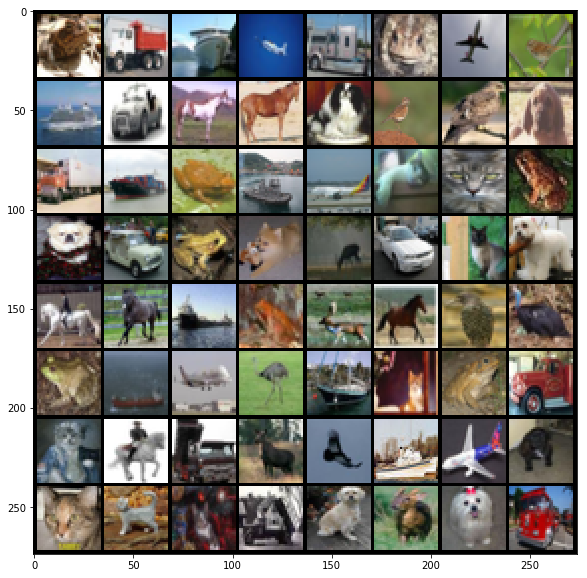

In [129]:
img = inputs[random.randint(0,64)]
plot_tensor(torchvision.utils.make_grid(inputs))

## CNN

In [130]:
def conv_bn_relu(in_chans, out_chans, kernel_size=3, stride=1, 
                 padding=1, bias=False):
    return [
        nn.Conv2d(in_chans, out_chans, kernel_size=kernel_size,
                  stride=stride, padding=padding, bias=bias),
        nn.BatchNorm2d(out_chans),
        nn.ReLU(inplace=True),
    ]

def linear_bn_relu_drop(in_chans, out_chans, dropout=0.5, bias=False):
    layers = [
        nn.Linear(in_chans, out_chans, bias=bias),
        nn.BatchNorm1d(out_chans),
        nn.ReLU(inplace=True)
    ]
    if dropout > 0:
        layers.append(nn.Dropout(dropout))
    return layers

class CNN(nn.Module):
    def __init__(self, in_shape, n_classes):
        super().__init__()
        c,w,h = in_shape
        pool_layers = 3
        fc_h = int(h / 2**pool_layers)
        fc_w = int(w / 2**pool_layers)
        self.features = nn.Sequential(
            *conv_bn_relu(c, 8, kernel_size=1, stride=1, padding=0),
            *conv_bn_relu(8, 32, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2), #size/2
            *conv_bn_relu(32, 32, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2), #size/2     
            *conv_bn_relu(32, 64, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2), #size/2
        )
        self.classifier = nn.Sequential(
            *linear_bn_relu_drop(64 * fc_h * fc_w, 256, dropout=0.25),
            nn.Linear(256, n_classes),
            nn.Softmax()
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [150]:
model = CNN(in_shape=(3,32,32), n_classes=10).cuda()
model

CNN(
  (features): Sequential(
    (0): Conv2d (3, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Conv2d (8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (7): Conv2d (32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (11): Conv2d (32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (13): ReLU(inplace)
    (14): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (classifier): Sequential(
    (0): Linear(in_features=1024, out_featu

In [ ]:
inputs,targets = next(iter(trn_loader))
output = model(Variable(inputs.cuda()))
output.size()

## Train

In [152]:
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
trainer = training.QuickTrainer()
trainer.run(model, trn_loader, tst_loader, criterion, optimizer, epochs=20)

/home/bfortuner/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 1, TrnLoss: 2.172, TrnAcc: 0.330, TstLoss: 2.092, TstAcc: 0.413
Epoch 2, TrnLoss: 2.047, TrnAcc: 0.445, TstLoss: 2.021, TstAcc: 0.458
Epoch 3, TrnLoss: 1.975, TrnAcc: 0.512, TstLoss: 1.992, TstAcc: 0.495
Epoch 4, TrnLoss: 1.921, TrnAcc: 0.561, TstLoss: 1.955, TstAcc: 0.519
Epoch 5, TrnLoss: 1.883, TrnAcc: 0.607, TstLoss: 1.923, TstAcc: 0.552
Epoch 6, TrnLoss: 1.853, TrnAcc: 0.629, TstLoss: 1.910, TstAcc: 0.563
Epoch 7, TrnLoss: 1.825, TrnAcc: 0.653, TstLoss: 1.893, TstAcc: 0.578
Epoch 8, TrnLoss: 1.815, TrnAcc: 0.665, TstLoss: 1.889, TstAcc: 0.583
Epoch 9, TrnLoss: 1.780, TrnAcc: 0.705, TstLoss: 1.899, TstAcc: 0.566
Epoch 10, TrnLoss: 1.773, TrnAcc: 0.707, TstLoss: 1.878, TstAcc: 0.584
Epoch 11, TrnLoss: 1.759, TrnAcc: 0.720, TstLoss: 1.876, TstAcc: 0.582
Epoch 12, TrnLoss: 1.739, TrnAcc: 0.737, TstLoss: 1.894, TstAcc: 0.570
Epoch 13, TrnLoss: 1.734, TrnAcc: 0.744, TstLoss: 1.874, TstAcc: 0.595
Epoch 14, TrnLoss: 1.718, TrnAcc: 0.759, TstLoss: 1.876, TstAcc: 0.592
Epoch 15, TrnLo

In [153]:
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
trainer.run(model, trn_loader, tst_loader, criterion, optimizer, epochs=10)

/home/bfortuner/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 1, TrnLoss: 1.630, TrnAcc: 0.844, TstLoss: 1.829, TstAcc: 0.634
Epoch 2, TrnLoss: 1.617, TrnAcc: 0.857, TstLoss: 1.824, TstAcc: 0.640
Epoch 3, TrnLoss: 1.615, TrnAcc: 0.860, TstLoss: 1.823, TstAcc: 0.638
Epoch 4, TrnLoss: 1.604, TrnAcc: 0.869, TstLoss: 1.821, TstAcc: 0.646
Epoch 5, TrnLoss: 1.611, TrnAcc: 0.862, TstLoss: 1.824, TstAcc: 0.635
Epoch 6, TrnLoss: 1.599, TrnAcc: 0.873, TstLoss: 1.819, TstAcc: 0.648
Epoch 7, TrnLoss: 1.602, TrnAcc: 0.871, TstLoss: 1.823, TstAcc: 0.644
Epoch 8, TrnLoss: 1.594, TrnAcc: 0.877, TstLoss: 1.822, TstAcc: 0.643
Epoch 9, TrnLoss: 1.596, TrnAcc: 0.877, TstLoss: 1.819, TstAcc: 0.646
Epoch 10, TrnLoss: 1.593, TrnAcc: 0.881, TstLoss: 1.816, TstAcc: 0.651


## Metrics

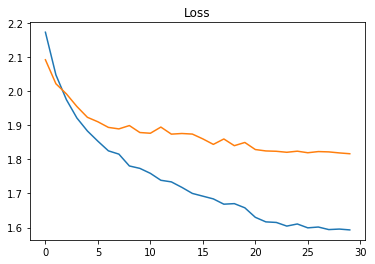

In [158]:
plt.title('Loss')
plt.plot(np.stack([trainer.metrics['loss']['trn'], trainer.metrics['loss']['tst']], 1));

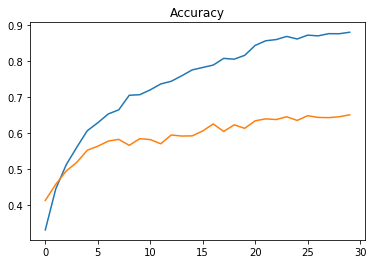

In [159]:
plt.title('Accuracy')
plt.plot(np.stack([trainer.metrics['accuracy']['trn'], trainer.metrics['accuracy']['tst']], 1));